# LSST Throughputs Curves

The LSST throughputs curves can be found in the [rubin_sim](https://github.com/lsst/rubin_sim) data download ($RUBIN_SIM_DATA_DIR/throughputs) or downloaded directly from https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/ (choose the latest 'throughputs' tar file).

The LSST-related values in this throughputs bundle are based on the inputs available from the LSST [syseng_throughputs](https://github.com/lsst-pst/syseng_throughputs) repo. 

----

In [1]:
# Import packages needed.
import os
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

from rubin_sim.data import get_data_dir
import rubin_sim.photUtils.Bandpass as Bandpass

The throughputs directory contains several subdirectories:

- baseline : this directory contains the current 'expected performance' curves for the LSST system.
- atmos : this directory contains standard atmosphere throughput curves at a range of airmasses between 1 and 2.5; the composition of the atmosphere is held constant, while the airmass changes.
- sdss : this directory contains the throughput curves for [SDSS](http://www.sdss.org/instruments/camera/)
- megacam : this directory contains the throughput curves for [CFHT's Megacam](http://www4.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html)
- There are also 2MASS, WISE, PanSTARRS, hipparcos, and tycho directories that contain throughput curves for each of these surveys.

There are README files in each directory with further information about their contents.

To generate expected LSST magnitudes, the "baseline" set of curves should be used. These curves include an atmosphere with X=1.2, corresponding to the median airmass of the atmosphere expected for LSST observations. 

In [2]:
# Read in the total ('final') throughput curves in each filter, and the atmosphere curve.
filterdir = os.path.join(get_data_dir(), 'throughputs', 'baseline')
lsst = {}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput(os.path.join(filterdir, 'total_'+f+'.dat'))
atmos = Bandpass()
atmos.readThroughput(os.path.join(filterdir, 'atmos_std.dat'))

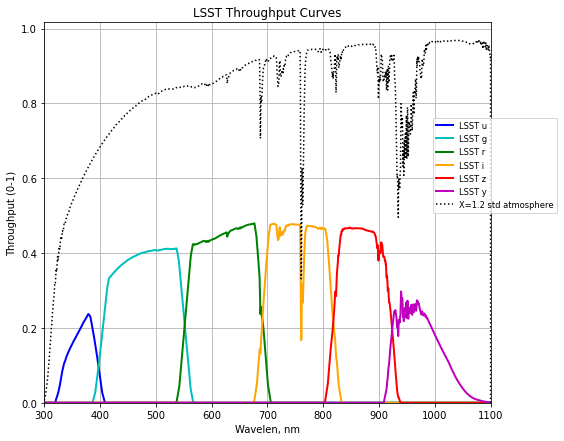

In [3]:
# Plot these curves alone.
plt.figure(figsize=(8,7))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))
plt.plot(atmos.wavelen, atmos.sb, 'k:', label='X=1.2 std atmosphere')
plt.xlabel('Wavelen, nm')
plt.ylabel('Throughput (0-1)')
plt.title('LSST Throughput Curves')
plt.xlim(300, 1100)
plt.legend(loc=(0.87, 0.5), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.ylim(bottom=0)
plt.savefig(os.path.join(filterdir, 'LSSTfilters.png'), format='png')

---
We may also want to compare these throughput curves with SDSS. 

In [4]:
sdssdir = os.path.join(get_data_dir(), 'throughputs', 'sdss')
sdss = {}
sdsslist = ('u', 'g', 'r', 'i', 'z')
for f in sdsslist:
    sdss[f] = Bandpass()
    sdss[f].readThroughput(os.path.join(sdssdir, 'sdss_'+f+'.dat'))

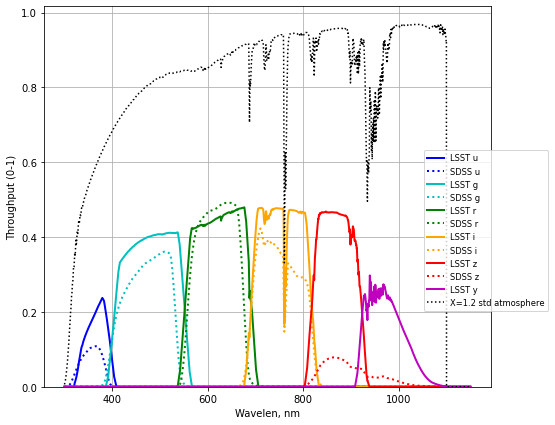

In [5]:
# Plot these curves alone.
plt.figure(figsize=(8,7))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='LSST %s' % (f))
    if f in sdss:
        plt.plot(sdss[f].wavelen, sdss[f].sb, color=filtercolors[f], linestyle=':',  lw=2, label='SDSS %s' % (f))
plt.plot(atmos.wavelen, atmos.sb, 'k:', label='X=1.2 std atmosphere')
plt.xlabel('Wavelen, nm')
plt.ylabel('Throughput (0-1)')
plt.legend(loc=(0.85, 0.2), fancybox=True, fontsize='smaller')
plt.ylim(bottom=0)
plt.grid(True)

Remembering that the total, above-atmosphere flux $F_b$ is calculated as
\begin{align}
F_b =  \int F_{\nu}(\lambda) \phi(\lambda) d\lambda
\end{align}
where $\phi(\lambda)$, the normalized system response is

\begin{align}
\phi(\lambda) = \frac {S_b(\lambda) / \lambda}{\sum S_b(\lambda) / \lambda}
\end{align}

it is also interesting to plot $\phi(\lambda)$. 

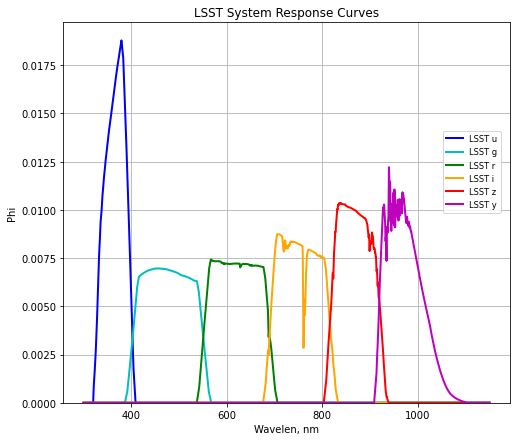

In [6]:
# Plot these curves alone.
plt.figure(figsize=(8,7))
for f in filterlist:
    lsst[f].sbTophi()
    plt.plot(lsst[f].wavelen, lsst[f].phi, color=filtercolors[f], lw=2, label='LSST %s' % (f))
plt.xlabel('Wavelen, nm')
plt.ylabel('Phi')
plt.title('LSST System Response Curves')
plt.legend(loc=(0.85, 0.5), fancybox=True, fontsize='smaller')
plt.ylim(bottom=0)
plt.grid(True)

----

It is also interesting to look at the contributions of the individual components contributing to the final throughput, including the detector QE, the 3 lens transmission curves, the filter transmission curve, the 3 mirror reflectivity curves and the atmosphere transmission.

In [7]:
# Read in each component separately.
allcommon_components = ['detector', 'lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3', 'atmos_std']
allcommon = {}
for c in allcommon_components:
    allcommon[c] = Bandpass()
    allcommon[c].readThroughput(os.path.join(filterdir, c +'.dat'))
# We probably won't want to show each component separately, as the plot will be quite messy. 
#  So let's batch up "mirrors" and "lenses" and the other components we will want to plot.
common = {}
common['detector'] = allcommon['detector']
common['atmosphere'] = allcommon['atmos_std']
common['mirrors'] = copy.deepcopy(allcommon['m1'])
common['mirrors'].sb = allcommon['m1'].sb * allcommon['m2'].sb * allcommon['m3'].sb
common['lenses'] = copy.deepcopy(allcommon['lens1'])
common['lenses'].sb = allcommon['lens1'].sb * allcommon['lens2'].sb * allcommon['lens3'].sb
# Note that we could have also combined these throughput curves using 'Bandpass.readThroughputList'
lsst_filters = {}
for f in filterlist:
    lsst_filters[f] = Bandpass()
    lsst_filters[f].readThroughput(os.path.join(filterdir, 'filter_'+f+'.dat'))

(0.0, 1.0437355119814813)

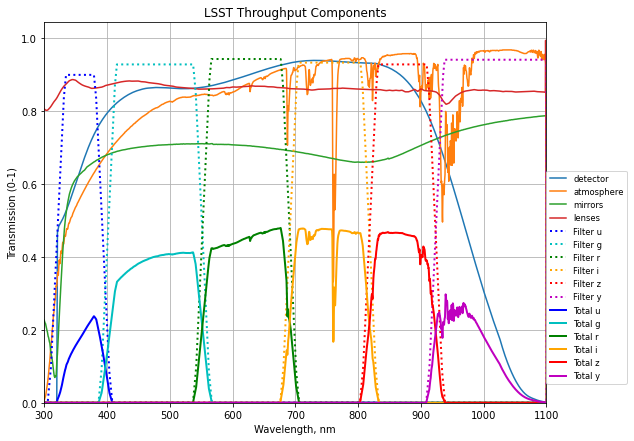

In [8]:
# Make a plot containing the total and component information.
plt.figure(figsize=(9,7))
for c in common:
    plt.plot(common[c].wavelen, common[c].sb, label=c)
for f in filterlist:
    plt.plot(lsst_filters[f].wavelen, lsst_filters[f].sb, color=filtercolors[f], linestyle=':', lw=2, label='Filter %s' % (f))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], lw=2, label='Total %s' % (f))
plt.xlabel('Wavelength, nm')
plt.ylabel('Transmission (0-1)')
plt.title('LSST Throughput Components')
plt.xlim(300, 1100)
plt.legend(loc=(1.0, 0.05), fancybox=True, fontsize='smaller')
plt.grid(True)
plt.ylim(bottom=0)

And finally, the `effective wavelength` can be useful information. This value is the wavelength weighted by the filter response; as such there is an effective wavelength associated with $\phi$ and one with $S_b$. 

\begin{align}
\lambda_{eff Phi}=  \frac {\sum \lambda \, \phi(\lambda)}{\sum \phi(\lambda)}
\end{align}

\begin{align}
\lambda_{eff Sb}=  \frac {\sum \lambda \, S_b(\lambda)}{\sum S_b(\lambda)}
\end{align}


In [9]:
# calculate effective wavelengths
effphi = {}
effsb = {}
for f in filterlist:
    effphi[f], effsb[f] = lsst[f].calcEffWavelen()
pd.DataFrame([effphi.values(), effsb.values()], columns=filterlist, index=['eff_phi', 'eff_sb'])

,u,g,r,i,z,y
eff_phi,365.972981,476.049524,620.461500,752.338120,868.025261,972.573072
eff_sb,366.991090,480.000488,623.143582,754.221998,869.103464,973.848914


<hr>

## Expected m5 values ##

Finally, we can calculate expected 5-sigma point source limiting magnitue values for these throughput curves, assuming dark-sky and observing at zenith.

In [10]:
from rubin_sim.photUtils import Sed
from rubin_sim.photUtils import calcM5
from rubin_sim.photUtils import LSSTdefaults, PhotometricParameters


# Read the dark sky SED
darksky = Sed()
darksky.readSED_flambda(os.path.join(get_data_dir(), 'throughputs', 'baseline', 'darksky.dat'))

In [11]:
# Read in each component separately, SWAP ATMOSPHERE FOR X=1.0 
common_components = ['detector', 'lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3', 'atmos_10']
common = Bandpass()
common.readThroughputList([os.path.join(filterdir, c +'.dat') for c in common_components])
lsst_filters = {}
for f in filterlist:
    lsst_filters[f] = Bandpass()
    lsst_filters[f].readThroughput(os.path.join(filterdir, 'filter_'+f+'.dat'))
    
lsst_zenith = {}
for f in filterlist:
    lsst_zenith[f] = Bandpass()
    lsst_zenith[f].wavelen, lsst_zenith[f].sb = lsst_filters[f].multiplyThroughputs(common.wavelen, common.sb)
    
# To calculate m5, we also need the throughputs without the atmosphere component
hardware = {}
for f in filterlist:
    hardware[f] = Bandpass()
    hardware[f].readThroughputList([os.path.join(filterdir, c +'.dat') for c in common_components 
                                    if not c.startswith('atmos')])
    wavelen, sb = hardware[f].multiplyThroughputs(lsst_filters[f].wavelen, lsst_filters[f].sb)
    hardware[f].wavelen = wavelen
    hardware[f].sb = sb

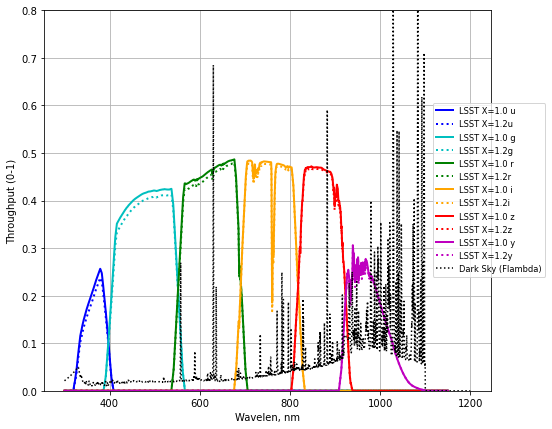

In [12]:
# Let's see what it looks like
plt.figure(figsize=(8,7))
for f in filterlist:
    plt.plot(lsst_zenith[f].wavelen, lsst_zenith[f].sb, color=filtercolors[f], lw=2, label='LSST X=1.0 %s' % (f))
    #plt.plot(hardware[f].wavelen, hardware[f].sb, color=filtercolors[f], lw=2, label='LSST X=1.0 %s' % (f))
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], linestyle=':',  lw=2, label='LSST X=1.2%s' % (f))
darksky.flambdaTofnu()
plt.plot(darksky.wavelen, darksky.flambda / darksky.flambda.max(), 'k:', label='Dark Sky (Flambda)')
plt.xlabel('Wavelen, nm')
plt.ylabel('Throughput (0-1)')
plt.legend(loc=(0.87, 0.3), fancybox=True, fontsize='smaller')
plt.ylim(bottom=0, top=0.8)
plt.grid(True)

To calculate m5 we will assume the LSST default FWHM (per filter) and typical camera parameters (readnoise, etc.)

In [13]:
# What are the default photometric parameter values?
photParams = PhotometricParameters()
print("Photometric Parameters:")
d = pd.DataFrame(photParams.__dict__, index=['Photometric parameters'])
d.columns = [c.strip('_') for c in d.columns]
d

Photometric Parameters:


,exptime,nexp,effarea,gain,platescale,sigmaSys,readnoise,darkcurrent,othernoise,bandpass
Photometric parameters,15.0,2,324015.454677,2.3,0.2,0.005,8.8,0.2,0.0,None


In [14]:
# What are the default FWHMeff values?
lsstDefaults = LSSTdefaults()
print("FWHM defaults (arcsecond):")
pd.DataFrame(lsstDefaults._FWHMeff, index=["FWHMeff"])

FWHM defaults (arcsecond):


,u,g,r,i,z,y
FWHMeff,0.92,0.87,0.83,0.8,0.78,0.76


In [15]:
# Calculate the individual image m5 depths
m5 = {}
for f in filterlist:
    m5[f] = calcM5(darksky, lsst_zenith[f], hardware[f], photParams, FWHMeff=lsstDefaults.FWHMeff(f))
    m5[f] = m5[f].round(2)
pd.DataFrame(m5, index=['Individual image m5'])

,u,g,r,i,z,y
Individual image m5,23.87,24.82,24.36,23.93,23.36,22.47


In [16]:
# And if we swap u band to 1x30s visits instead of 2x15
photParams30 = PhotometricParameters(nexp=1, exptime=30)

m5 = {}
for f in filterlist:
    if f == 'u':
        m5[f] = calcM5(darksky, lsst_zenith[f], hardware[f], photParams30, FWHMeff=lsstDefaults.FWHMeff(f))
    else:
        m5[f] = calcM5(darksky, lsst_zenith[f], hardware[f], photParams, FWHMeff=lsstDefaults.FWHMeff(f))
    m5[f] = m5[f].round(2)
pd.DataFrame(m5, index=['Individual image m5'])

,u,g,r,i,z,y
Individual image m5,24.07,24.82,24.36,23.93,23.36,22.47
